## Training on mfcc features extracted by librosa 

### Extracting features using librosa

In [1]:
# standard 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libs for audio
from scipy.io import wavfile as wav
import librosa

# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.base import clone
import random

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import utils
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score


In [2]:
def extract_features_librosa(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13) # 40
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [3]:
# Read Data
df = pd.read_csv("D:/SUTD/ISTD/Term 6/cds/Project/FULL DATASET_edited.csv")
y = df['PHQ_Binary']
x = df['Participant_ID']


features = []

# Audio files with lots of static
prob = [300, 305, 306, 308, 315, 316, 343, 354, 362, 375, 378, 381, 382, 385, 387, 388, 390, 392, 393, 395, 408, 413, 421, 438, 473, 476, 479, 490, 492]
for index, audio_num in enumerate(x):
    if audio_num not in prob:
        try:
            fn = 'D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/{}_AUDIO_p.wav'.format(audio_num)
            print(fn)
            features.append([audio_num,extract_features_librosa(fn),y[index]])
        except Exception as e:
            print(e)
        """ librosa_audio, librosa_sample_rate = librosa.load(fn)
        scipy_sample_rate, scipy_audio = wav.read(fn) """

featuresdf = pd.DataFrame(features,columns = ['Participant_ID','feature','PHQ8_Binary'])
featuresdf.to_csv('librosa_mfcc_feature_13.csv')

D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/301_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/302_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/303_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/304_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/307_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/309_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/310_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/311_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/312_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/313_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/314_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/317_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/318_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/319_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/320_AUDIO_p.wav
D:/SUTD/ISTD/Term 6/cds/Project/Audio/pr

### Training

#### Read data

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

data = pd.read_csv("librosa_mfcc_feature_13.csv")

# to convert X (features) to np array
def remove_brackets(s):
    new_s = s[1:-1]
    return new_s

def str_to_np(X):
    new_X = []
    for i in range(len(X)):
        x_i = np.fromstring(X.iloc[i], dtype=float, sep='\t')
        new_X.append(x_i)
    return np.stack( new_X, axis=0 )


#print(data)
data['feature'] = data['feature'].apply(remove_brackets)
X = data['feature']
X = str_to_np(X)
#print(X)
Y= data['PHQ8_Binary'].values
data['PHQ8_Binary'] = data['PHQ8_Binary'].values
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE)
#print(data['Participant_ID'].values)
print(X_train.shape)
print(y_train.shape)
#print(X[0].shape)
#print(len(X[1]))
#np.save("participants_audio.npy",data['Participant_ID'])
np.save("X_audio_librosa.npy",X_test)
np.save("Y_test_audio.npy",y_test)

(106, 13)
(106,)


#### Evaluation

In [5]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

In [6]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

#### K cross

In [7]:
def k_cross(input_model, X=X_train, y=y_train, k=4, n=3, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
                
        model = clone(input_model) # prevents incremental fitting
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

### Models implementation

#### Gaussian Naive Bayes 

f1 mean score: 0.28334533113944876
recall mean score: 0.2966880341880342
[0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5385395537525355
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        29
           1       0.43      0.35      0.39        17

    accuracy                           0.59        46
   macro avg       0.54      0.54      0.54        46
weighted avg       0.57      0.59      0.58        46

Confusion Matrix: 
 [[21  8]
 [11  6]]


GaussianNB()

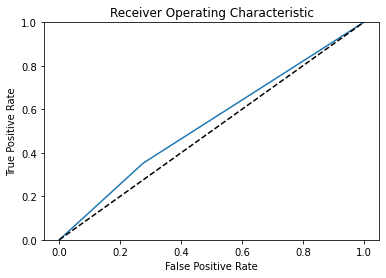

In [8]:
nb_model = GaussianNB()

f1_scores, recall_scores = k_cross(nb_model)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

evaluate_model(nb_model)

#### Logistic Regression

best scores: f1 = 0.20515873015873012, recall = 0.16269332519332516
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.6125760649087222
              precision    recall  f1-score   support

           0       0.69      0.93      0.79        29
           1       0.71      0.29      0.42        17

    accuracy                           0.70        46
   macro avg       0.70      0.61      0.61        46
weighted avg       0.70      0.70      0.65        46

Confusion Matrix: 
 [[27  2]
 [12  5]]


LogisticRegression(C=100, n_jobs=3)

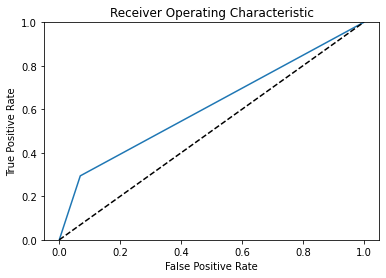

In [9]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_logreg_f1_model = find_best_logreg_model(6)
evaluate_model(best_logreg_f1_model)

#### Decision Tree

best scores: f1 = 0.37125039317208514, recall = 0.43497150997150996
[0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0
 0 0 0 1 0 0 1 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.6217038539553753
              precision    recall  f1-score   support

           0       0.73      0.66      0.69        29
           1       0.50      0.59      0.54        17

    accuracy                           0.63        46
   macro avg       0.62      0.62      0.62        46
weighted avg       0.65      0.63      0.64        46

Confusion Matrix: 
 [[19 10]
 [ 7 10]]


DecisionTreeClassifier(max_depth=2, min_samples_leaf=17, random_state=42)

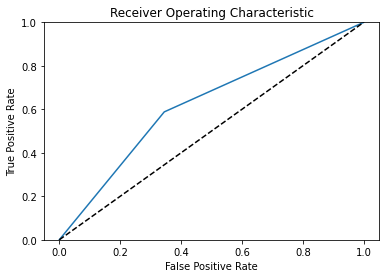

In [10]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                best_f1 = f1
                best_recall = recall
                best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_tree_f1_model = find_best_tree_model(20, 30)
evaluate_model(best_tree_f1_model)

#### Random Forest

best scores: f1 = 0.2843465594433087, recall = 0.3098010785510786
[0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.526369168356998
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        29
           1       0.42      0.29      0.34        17

    accuracy                           0.59        46
   macro avg       0.53      0.53      0.52        46
weighted avg       0.56      0.59      0.57        46

Confusion Matrix: 
 [[22  7]
 [12  5]]


RandomForestClassifier(n_estimators=1, random_state=42)

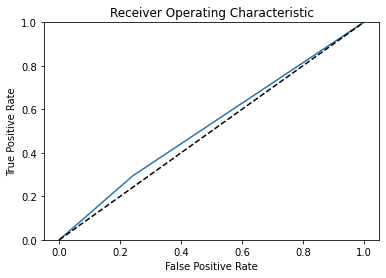

In [11]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_forest_f1_model = find_best_forest_model(30)
evaluate_model(best_forest_f1_model)

#### SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    7.6s finished
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s
Fitting 10 folds for each of 18 candidates, totalling 180

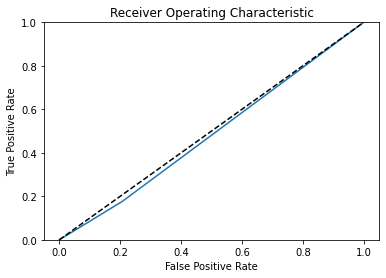

In [12]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")

## Saving model for UI

In [13]:
import pickle
pickle.dump(best_tree_f1_model, open('../../UI/model.pkl','wb'))